In [1]:
#!pip install numpy
#!pip install sklearn

In [2]:
import numpy as np
import sklearn as skl
import scipy

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# TP2: Détection de menaces radar

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

2 séances de TP sur ce sujet : le 16 octobre (1h30) et le 23 octobre (3h).<br> 
Deadline : 30 otobre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.
    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués 
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

In [4]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import json


In [42]:
pdws = np.load('./radars/train/pdw-0.npz')
dates = pdws['date']
largeurs = pdws['largeur']
frequences= pdws['puissance']
puissances = pdws['puissance']
theta = pdws['theta']
phi = pdws['phi']


<div class=consignes> et les fichiers d'annotations:</div>

In [43]:
import json

with open('./radars/train_labels.json') as f: 
    dict_train_labels = json.load(f)

# Load labels of test set
with open('./radars/test_labels.json') as f: 
    dict_test_labels = json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_train_labels[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: nonmenace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: nonmenace


<div class=consignes> On compte sur vous, bonne chance ! </div>

## Load a sample to explore data

### Explore the sample to check how to access data and label

In [44]:
# Print length and first element, of each features for a given signal

# Available features
column_names = ['date', 'largeur', 'frequence', 'puissance', 'theta', 'phi']

# For each available features
for col in column_names:

  # Print length (number of element for a given signal)
  print("Length for feature ", col, ": ", len(pdws[col]))

  # Print first element
  print("First element for feature ", col, ": ", pdws[col][0], "\n")

# Print label of this signal
print(f"Label of signal pdw-{0}.npz is a: {dict_train_labels[f'pdw-{0}']}")

Length for feature  date :  672
First element for feature  date :  1.31 

Length for feature  largeur :  672
First element for feature  largeur :  0.291 

Length for feature  frequence :  672
First element for feature  frequence :  2.2220113463017723 

Length for feature  puissance :  672
First element for feature  puissance :  -125.58248735699023 

Length for feature  theta :  672
First element for feature  theta :  0.9578859532471261 

Length for feature  phi :  672
First element for feature  phi :  1.678935775441994 

Label of signal pdw-0.npz is a: nonmenace


________________
# Partie 1 : Exploration

## 1.1 - Exploration visuelle pour un signal donné

On représente la largeur, la fréquence, la puissance, theta et phi dans le temps

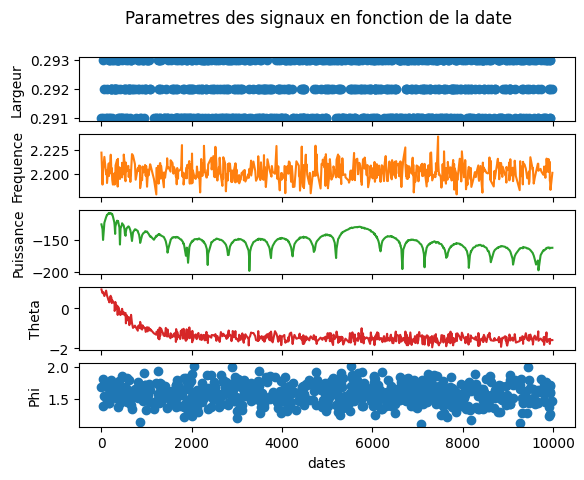

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
fig.suptitle('Parametres des signaux en fonction de la date')
ax1.scatter(pdws['date'], pdws['largeur'])
ax1.set(ylabel='Largeur')
ax2.plot(pdws['date'], pdws['frequence'], 'tab:orange')
ax2.set( ylabel='Frequence')
ax3.plot(pdws['date'], pdws['puissance'], 'tab:green')
ax3.set(ylabel='Puissance')
ax4.plot(pdws['date'], pdws['theta'], 'tab:red')
ax4.set(ylabel='Theta')
ax5.scatter(pdws['date'], pdws['phi'])
ax5.set(xlabel='dates', ylabel='Phi')


for ax in fig.get_axes():
    ax.label_outer()
plt.show()


## 1.2  Load data for every sample

Désormais, un travail sur les données sera réalisé afin de créer le dataset final pour l'entrainement des modèles.

In [46]:
# Lecture des labels pour l'echantillon train, puis test
train_labels  = []

test_labels  = []

# Train
for i in range(len(dict_train_labels)):
  train_labels.append(dict_train_labels[f'pdw-{i}'])


# Test
for i in range(len(dict_test_labels)):
  test_labels.append(dict_test_labels[f'pdw-{i}'])

Création d'un dictionnaire pour stocker toutes les données de la forme {date:[signal1, signal2...], frequence:[signal1, signal2...] ...}.

In [47]:
# Load data 
dict_train_2, dict_test = {}, {}

dict_train_2['date'], dict_train_2['largeur'], dict_train_2['frequence'] = {}, {}, {}
dict_train_2['puissance'], dict_train_2['theta'], dict_train_2['phi'] = {}, {}, {}
dict_train_2['labels'] = {}

dict_test['date'], dict_test['largeur'], dict_test['frequence'] = {}, {}, {}
dict_test['puissance'], dict_test['theta'], dict_test['phi'] = {}, {}, {}
dict_test['labels'] = {}

# TRAIN
for i in range(len(dict_train_labels)):

  # Load current sample
  path_current_sample = os.path.join("./radars/train/", "pdw-"+str(i)+".npz")
  pdws = np.load(path_current_sample)

  # Get features of this sample
  dict_train_2['date'][i] = pdws['date']
  dict_train_2['largeur'][i] = pdws['largeur']
  dict_train_2['frequence'][i] = pdws['frequence']
  dict_train_2['puissance'][i] = pdws['puissance']
  dict_train_2['theta'][i] = pdws['theta']
  dict_train_2['phi'][i] = pdws['phi']

  # Get label
  dict_train_2['labels'][i] = dict_train_labels[f'pdw-{i}']

#TEST
for i in range(len(dict_test_labels)):

  # Load current sample
  path_current_sample = os.path.join("./radars/test/", "pdw-"+str(i)+".npz")
  pdws = np.load(path_current_sample)

  # Get features of this sample
  dict_test['date'][i] = pdws['date']
  dict_test['largeur'][i] = pdws['largeur']
  dict_test['frequence'][i] = pdws['frequence']
  dict_test['puissance'][i] = pdws['puissance']
  dict_test['theta'][i] = pdws['theta']
  dict_test['phi'][i] = pdws['phi']

  # Get label
  dict_test['labels'][i] = dict_test_labels[f'pdw-{i}']


## 1.3 - Exploration visuelle du jeu de données

Dans cette partie, on propose de comparer les différentes valeurs des variables, pour chaque label. Afin de voir si des différentes peuvent être facilement observées.

#### Exploration des labels

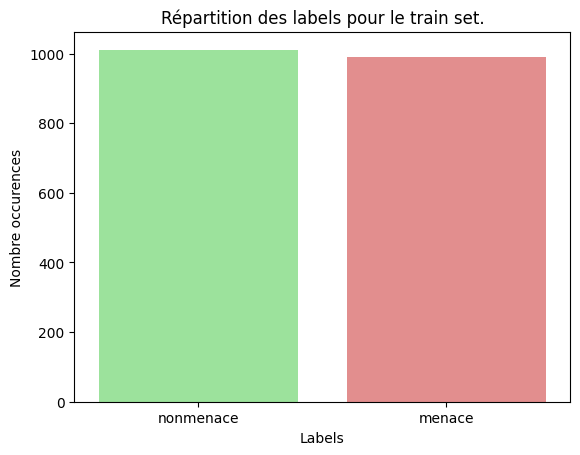

In [48]:
# Pour le train set
sns.countplot(x = train_labels, palette = ['lightgreen', 'lightcoral'], hue= train_labels)

plt.title("Répartition des labels pour le train set.")
plt.xlabel('Labels')
plt.ylabel('Nombre occurences')

plt.show()

## Exploration des variables pour chaque label

### [0/5] - Date

On cherche a calculer l'interval de temps entre les differentes impulsions pour en tirer quelques features. 

In [49]:
date_train = list(dict_train_2['date'].values())

def compute_date_features(date):
    PIR = np.diff(date)
    mean = PIR.mean()
    std = PIR.std()
    min = PIR.min()
    max = PIR.max()
    return mean, std, min, max

N= len(date_train)
date_features = np.zeros((N,4))

for i in range(N):
    date_features[i,:] = compute_date_features(date_train[i])

df_date = pd.DataFrame(date_features, columns=["mean_PIR", "std_PIR", "min_PIR", "max_PIR"])
df_date

,mean_PIR,std_PIR,min_PIR,max_PIR
0,14.879808,13.625174,1.477,84.352
1,9.254787,8.865874,0.915,65.119
2,15.697808,14.843119,1.576,113.615
3,6.956272,6.788928,0.682,60.198
4,16.485491,16.202166,1.653,125.830
...,...,...,...,...
1995,9.022126,8.343726,0.879,53.743
1996,9.886374,9.144113,0.977,60.743
1997,2.459299,2.333512,0.241,19.455
1998,5.896918,5.827750,0.579,49.990


### [1/5] - Fréquence

On peut voir que la frequence permet de differencier les signaux contenant un menace des signaux n'en contenant pas. On utilisera ce feature pour faire un algorithme naif de classification. 

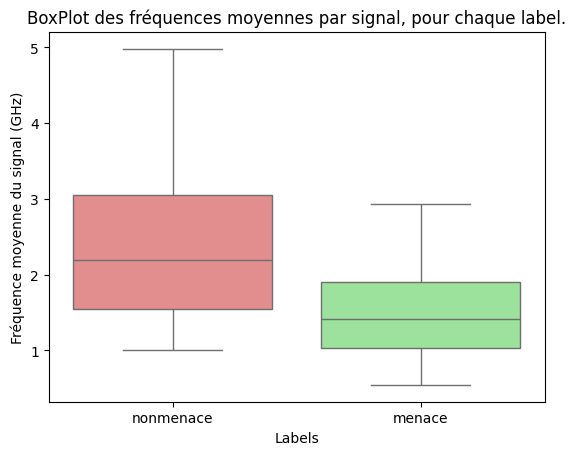

In [50]:
# BoxPlot de la moyenne des fréquences : MENANCE vs NON-MENACE

# Extract data
frequence_train = list(dict_train_2['frequence'].values())
frequence_train_mean = [sum(sub_list) / len(sub_list) for sub_list in frequence_train]

# BoxPlot
sns.boxplot(x = train_labels, y = frequence_train_mean, palette = ['lightcoral', 'lightgreen'], hue=train_labels)

plt.title("BoxPlot des fréquences moyennes par signal, pour chaque label.")
plt.xlabel('Labels')
plt.ylabel('Fréquence moyenne du signal (GHz)')

plt.show()

On propose de prendre en compte un parametre additionnel relier a la frequence pour essayer d'ameliorer la classification:

In [51]:
def compute_frequence_features(frequence):
    mean = frequence.mean()
    std = frequence.std()
    central_f = (min(frequence) + max(frequence))/2
    return mean, std, central_f

N= len(frequence_train)
freq_features = np.zeros((N,3))

for i in range(N):
    freq_features[i,:] = compute_frequence_features(frequence_train[i])

df_freq = pd.DataFrame(freq_features, columns=["mean_f", "std_f", "central_f"])
df_freq


,mean_f,std_f,central_f
0,2.202149,0.008909,2.208671
1,2.996037,0.012328,2.989099
2,0.986435,0.004003,0.985203
3,1.665592,0.006610,1.665870
4,2.205039,0.008529,2.206188
...,...,...,...
1995,1.247535,0.070869,1.246563
1996,1.878550,0.109245,1.883728
1997,1.917764,0.007621,1.918861
1998,2.040005,0.008051,2.038934


### [2/5] - Puissance

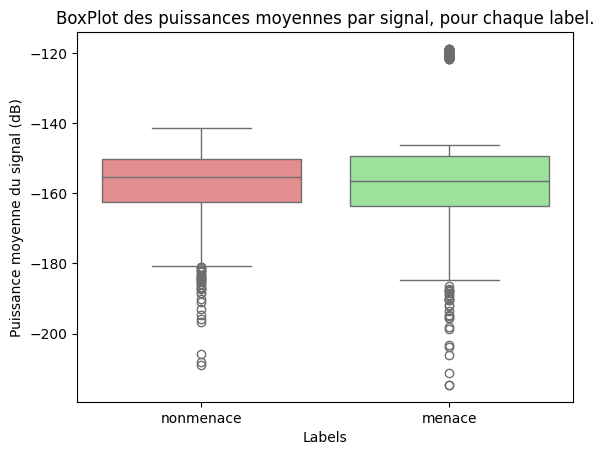

In [52]:
# BoxPlot de la moyenne des puissances : MENANCE vs NON-MENACE

# Extract data
puissance_train = list(dict_train_2['puissance'].values())
puissance_train_mean = [sum(sub_list) / len(sub_list) for sub_list in puissance_train]

# BoxPlot
sns.boxplot(x = train_labels, y = puissance_train_mean, palette = ['lightcoral', 'lightgreen'], hue=train_labels)

plt.title("BoxPlot des puissances moyennes par signal, pour chaque label.")
plt.xlabel('Labels')
plt.ylabel('Puissance moyenne du signal (dB)')

plt.show()

On propose de prendre en compte un parametre additionnel relier a la puissance pour essayer d'ameliorer la classification:

In [53]:
def compute_puissance_features(puissance, date):
    mean = puissance.mean()
    std = puissance.std()
    min = puissance.min()
    max = puissance.max()

    #calcul le nombre de pic dans le signal
    peaks = scipy.signal.find_peaks(puissance,prominence=5, distance=5)[0]
    n_peaks = len(peaks)
    #calcul la frequence a laquelle les pics apparaissent
    main_f = np.diff(peaks).mean()

    return mean, std, min, max, n_peaks, main_f

N= len(puissance_train)
puissance_features = np.zeros((N,6))

for i in range(N):
    puissance_features[i,:] = compute_puissance_features(puissance_train[i], date_train[i])

df_puiss = pd.DataFrame(puissance_features, columns=["mean_p", "std_p", "min_p","max_p", "n_peaks_p", "main_f_p"])
df_puiss



C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_9228\2907287659.py:11: RuntimeWarning: Mean of empty slice.
  main_f = np.diff(peaks).mean()
C:\Users\DAO.EZSPACE\anaconda3\envs\mva2\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,mean_p,std_p,min_p,max_p,n_peaks_p,main_f_p
0,-151.168286,14.271022,-198.439372,-107.706444,25.0,26.750000
1,-152.733649,11.655734,-210.067261,-127.176800,14.0,73.000000
2,-171.253159,12.164566,-232.867752,-145.868879,25.0,23.583333
3,-149.829714,9.564745,-209.155813,-132.493661,7.0,155.833333
4,-177.214144,11.162828,-232.332658,-148.379465,12.0,51.818182
...,...,...,...,...,...,...
1995,-184.618028,13.209612,-270.337771,-150.112861,30.0,36.310345
1996,-147.789485,11.059385,-198.814953,-125.834376,11.0,87.500000
1997,-148.943209,13.187461,-223.646197,-120.246247,15.0,273.428571
1998,-151.170110,10.765854,-201.795828,-121.686685,12.0,142.454545


### [3/5] - Largeur

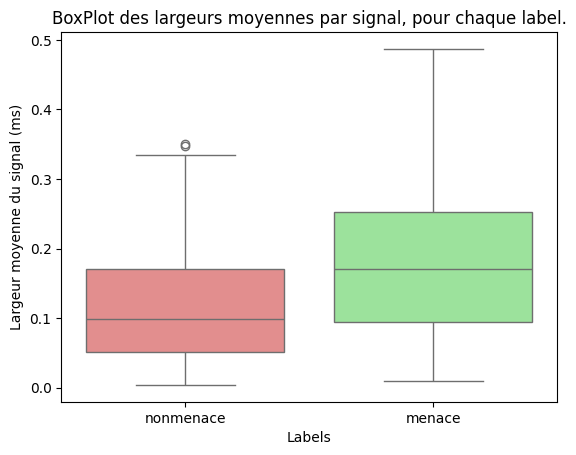

In [54]:
# BoxPlot de la moyenne des largeurs : MENANCE vs NON-MENACE

# Extract data
largeur_train = list(dict_train_2['largeur'].values())
largeur_train_mean = [sum(sub_list) / len(sub_list) for sub_list in largeur_train]

# BoxPlot
sns.boxplot(x = train_labels, y = largeur_train_mean, palette = ['lightcoral', 'lightgreen'], hue=train_labels)

plt.title("BoxPlot des largeurs moyennes par signal, pour chaque label.")
plt.xlabel('Labels')
plt.ylabel('Largeur moyenne du signal (ms)')

plt.show()

In [55]:
def compute_largeur_features(largeur):
    mean = largeur.mean()
    std = largeur.std()
    min = largeur.min()
    max = largeur.max()

    return mean, std, min, max

N= len(largeur_train)
largeur_features = np.zeros((N,4))

for i in range(N):
    largeur_features[i,:] = compute_largeur_features(largeur_train[i])

df_larg = pd.DataFrame(largeur_features, columns=["mean_l", "std_l", "min_l","max_l"])
df_larg

,mean_l,std_l,min_l,max_l
0,0.292003,0.000829,0.291,0.293
1,0.137017,0.000810,0.136,0.138
2,0.201962,0.000824,0.201,0.203
3,0.069014,0.000813,0.068,0.070
4,0.324018,0.000813,0.323,0.325
...,...,...,...,...
1995,0.143991,0.000815,0.143,0.145
1996,0.159961,0.000818,0.159,0.161
1997,0.028000,0.000817,0.027,0.029
1998,0.107006,0.000818,0.106,0.108


### [4/5] - Theta

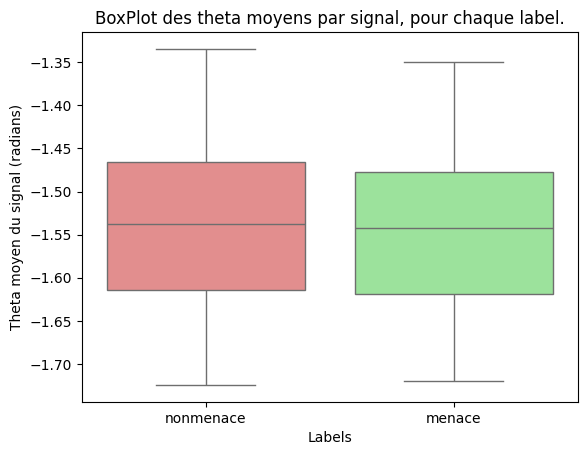

In [56]:
# BoxPlot de la moyenne des theta : MENANCE vs NON-MENACE

# Extract data
theta_train = list(dict_train_2['theta'].values())
theta_train_mean = [sum(sub_list) / len(sub_list) for sub_list in theta_train]

# BoxPlot
sns.boxplot(x = train_labels, y = theta_train_mean, palette = ['lightcoral', 'lightgreen'], hue= train_labels)

plt.title("BoxPlot des theta moyens par signal, pour chaque label.")
plt.xlabel('Labels')
plt.ylabel('Theta moyen du signal (radians)')

plt.show()

In [57]:
def compute_theta_features(theta,date):
    mean = theta.mean()
    std = theta.std()
    min = theta.min()
    max = theta.max()
    theta_rate = np.max(np.diff(theta)/np.diff(date))

    return mean, std, min, max, theta_rate

N= len(theta_train)
theta_features = np.zeros((N,5))

for i in range(N):
    theta_features[i,:] = compute_theta_features(theta_train[i], date_train[i])

df_theta = pd.DataFrame(theta_features, columns=["mean_t", "std_t", "min_t","max_t","theta_rate"])
df_theta

,mean_t,std_t,min_t,max_t,theta_rate
0,-1.334458,0.477428,-1.954106,0.957886,0.438689
1,-1.634125,0.347991,-3.133343,3.100138,0.730794
2,-1.607840,0.163853,-2.287829,-1.075253,0.362154
3,-1.690380,0.213341,-2.701142,-1.125655,0.941412
4,-1.559266,0.674727,-3.058637,3.387907,0.387284
...,...,...,...,...,...
1995,-1.574284,0.522763,-2.956647,3.302977,0.553626
1996,-1.563371,0.843644,-3.328064,3.211503,0.441537
1997,-1.513623,0.175318,-2.162857,-0.812144,2.500314
1998,-1.527002,0.172370,-2.004503,-0.723425,0.988232


### [5/5] - Phi

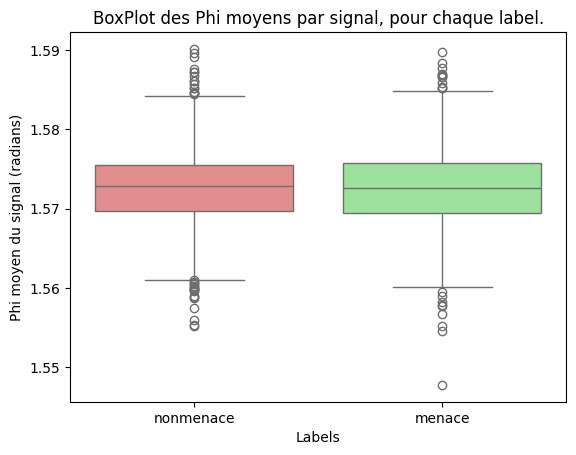

In [58]:
# BoxPlot de la moyenne des phi : MENANCE vs NON-MENACE

# Extract data
phi_train = list(dict_train_2['phi'].values())
phi_train_mean = [sum(sub_list) / len(sub_list) for sub_list in phi_train]

# BoxPlot
sns.boxplot(x = train_labels, y = phi_train_mean, palette = ['lightcoral', 'lightgreen'], hue=train_labels)

plt.title("BoxPlot des Phi moyens par signal, pour chaque label.")
plt.xlabel('Labels')
plt.ylabel('Phi moyen du signal (radians)')

plt.show()

In [59]:
def compute_phi_features(phi, date, theta):
    mean = phi.mean()
    std = phi.std()
    min = phi.min()
    max = phi.max()
    phi_rate = np.max(np.diff(phi)/np.diff(date))
    ang_v = np.sqrt(np.diff(phi)**2 + np.diff(theta)**2).mean()


    return mean, std, min, max, phi_rate, ang_v

N= len(phi_train)
phi_features = np.zeros((N,6))

for i in range(N):
    phi_features[i,:] = compute_phi_features(phi_train[i], date_train[i], theta_train[i])

df_phi = pd.DataFrame(phi_features, columns=["mean_phi", "std_phi", "min_phi","max_phi", "phi_rate", "ang_v"])
df_phi

,mean_phi,std_phi,min_phi,max_phi,phi_rate,ang_v
0,1.574437,0.155398,1.097684,2.018851,0.425634,0.285496
1,1.570940,0.161758,1.000649,2.207375,0.637330,0.279969
2,1.571787,0.154042,1.116303,2.021743,0.393122,0.270892
3,1.585633,0.162123,0.998426,2.210000,0.963273,0.281875
4,1.578277,0.161913,0.836817,2.092829,0.338443,0.300186
...,...,...,...,...,...,...
1995,1.574064,0.161461,1.174471,2.138309,0.552991,0.285385
1996,1.575663,0.158298,1.110255,2.063434,0.740066,0.281168
1997,1.572314,0.156688,1.106590,2.159081,2.395023,0.276250
1998,1.574144,0.153207,1.102551,2.088708,0.956172,0.274557


In [60]:
#assemblage final de tous les features 
df_features_train = pd.concat((df_date, df_freq, df_puiss, df_larg, df_theta, df_phi), axis=1)
df_features_train

,mean_PIR,std_PIR,min_PIR,max_PIR,mean_f,std_f,central_f,mean_p,std_p,min_p,...,std_t,min_t,max_t,theta_rate,mean_phi,std_phi,min_phi,max_phi,phi_rate,ang_v
0,14.879808,13.625174,1.477,84.352,2.202149,0.008909,2.208671,-151.168286,14.271022,-198.439372,...,0.477428,-1.954106,0.957886,0.438689,1.574437,0.155398,1.097684,2.018851,0.425634,0.285496
1,9.254787,8.865874,0.915,65.119,2.996037,0.012328,2.989099,-152.733649,11.655734,-210.067261,...,0.347991,-3.133343,3.100138,0.730794,1.570940,0.161758,1.000649,2.207375,0.637330,0.279969
2,15.697808,14.843119,1.576,113.615,0.986435,0.004003,0.985203,-171.253159,12.164566,-232.867752,...,0.163853,-2.287829,-1.075253,0.362154,1.571787,0.154042,1.116303,2.021743,0.393122,0.270892
3,6.956272,6.788928,0.682,60.198,1.665592,0.006610,1.665870,-149.829714,9.564745,-209.155813,...,0.213341,-2.701142,-1.125655,0.941412,1.585633,0.162123,0.998426,2.210000,0.963273,0.281875
4,16.485491,16.202166,1.653,125.830,2.205039,0.008529,2.206188,-177.214144,11.162828,-232.332658,...,0.674727,-3.058637,3.387907,0.387284,1.578277,0.161913,0.836817,2.092829,0.338443,0.300186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9.022126,8.343726,0.879,53.743,1.247535,0.070869,1.246563,-184.618028,13.209612,-270.337771,...,0.522763,-2.956647,3.302977,0.553626,1.574064,0.161461,1.174471,2.138309,0.552991,0.285385
1996,9.886374,9.144113,0.977,60.743,1.878550,0.109245,1.883728,-147.789485,11.059385,-198.814953,...,0.843644,-3.328064,3.211503,0.441537,1.575663,0.158298,1.110255,2.063434,0.740066,0.281168
1997,2.459299,2.333512,0.241,19.455,1.917764,0.007621,1.918861,-148.943209,13.187461,-223.646197,...,0.175318,-2.162857,-0.812144,2.500314,1.572314,0.156688,1.106590,2.159081,2.395023,0.276250
1998,5.896918,5.827750,0.579,49.990,2.040005,0.008051,2.038934,-151.170110,10.765854,-201.795828,...,0.172370,-2.004503,-0.723425,0.988232,1.574144,0.153207,1.102551,2.088708,0.956172,0.274557


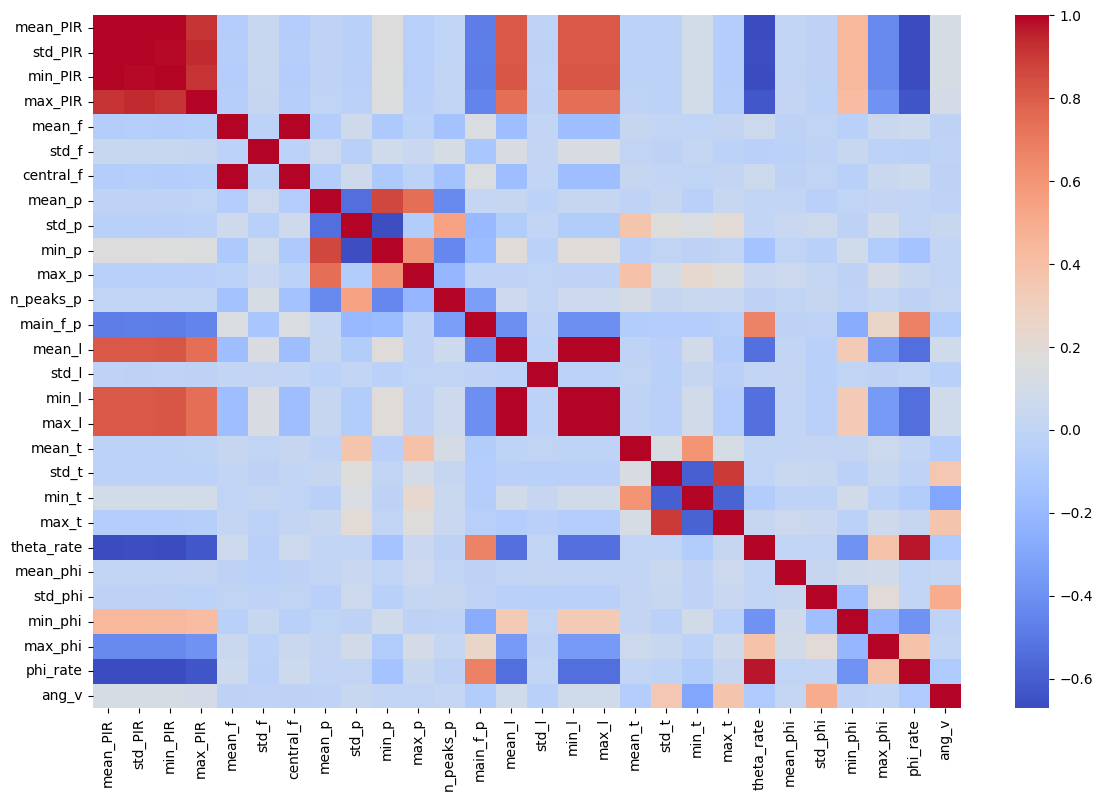

In [61]:
#on trace la matrice de correlation entre les different features pour mieux comprendre leur lien
cor_df = df_features_train.corr()

plt.figure(figsize=(14,9))
sns.heatmap(cor_df, annot=False, cmap= 'coolwarm')
plt.show()



# Partie 2. Algorithme de classification


### 2.1. Algorithme de reference (Naif)

2.1.1. Preparation des donnees

In [62]:
df_features_train = pd.concat((df_features_train, pd.DataFrame(train_labels, columns=['labels'])), axis=1)
df_features_train

,mean_PIR,std_PIR,min_PIR,max_PIR,mean_f,std_f,central_f,mean_p,std_p,min_p,...,min_t,max_t,theta_rate,mean_phi,std_phi,min_phi,max_phi,phi_rate,ang_v,labels
0,14.879808,13.625174,1.477,84.352,2.202149,0.008909,2.208671,-151.168286,14.271022,-198.439372,...,-1.954106,0.957886,0.438689,1.574437,0.155398,1.097684,2.018851,0.425634,0.285496,nonmenace
1,9.254787,8.865874,0.915,65.119,2.996037,0.012328,2.989099,-152.733649,11.655734,-210.067261,...,-3.133343,3.100138,0.730794,1.570940,0.161758,1.000649,2.207375,0.637330,0.279969,nonmenace
2,15.697808,14.843119,1.576,113.615,0.986435,0.004003,0.985203,-171.253159,12.164566,-232.867752,...,-2.287829,-1.075253,0.362154,1.571787,0.154042,1.116303,2.021743,0.393122,0.270892,menace
3,6.956272,6.788928,0.682,60.198,1.665592,0.006610,1.665870,-149.829714,9.564745,-209.155813,...,-2.701142,-1.125655,0.941412,1.585633,0.162123,0.998426,2.210000,0.963273,0.281875,nonmenace
4,16.485491,16.202166,1.653,125.830,2.205039,0.008529,2.206188,-177.214144,11.162828,-232.332658,...,-3.058637,3.387907,0.387284,1.578277,0.161913,0.836817,2.092829,0.338443,0.300186,nonmenace
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9.022126,8.343726,0.879,53.743,1.247535,0.070869,1.246563,-184.618028,13.209612,-270.337771,...,-2.956647,3.302977,0.553626,1.574064,0.161461,1.174471,2.138309,0.552991,0.285385,menace
1996,9.886374,9.144113,0.977,60.743,1.878550,0.109245,1.883728,-147.789485,11.059385,-198.814953,...,-3.328064,3.211503,0.441537,1.575663,0.158298,1.110255,2.063434,0.740066,0.281168,menace
1997,2.459299,2.333512,0.241,19.455,1.917764,0.007621,1.918861,-148.943209,13.187461,-223.646197,...,-2.162857,-0.812144,2.500314,1.572314,0.156688,1.106590,2.159081,2.395023,0.276250,menace
1998,5.896918,5.827750,0.579,49.990,2.040005,0.008051,2.038934,-151.170110,10.765854,-201.795828,...,-2.004503,-0.723425,0.988232,1.574144,0.153207,1.102551,2.088708,0.956172,0.274557,menace


In [63]:
#creation du test set

date_test = list(dict_test['date'].values())
frequence_test = list(dict_test['frequence'].values())
puissance_test = list(dict_test['puissance'].values())
largeur_test = list(dict_test['largeur'].values())
theta_test = list(dict_test['theta'].values())
phi_test = list(dict_test['phi'].values())

N= len(date_test)
date_features = np.zeros((N,4))
freq_features = np.zeros((N,3))
puissance_features = np.zeros((N,6))
largeur_features = np.zeros((N,4))
theta_features = np.zeros((N,5))
phi_features = np.zeros((N,6))


for i in range(N):
    date_features[i,:] = compute_date_features(date_test[i])
    freq_features[i,:] = compute_frequence_features(frequence_test[i])
    puissance_features[i,:] = compute_puissance_features(puissance_test[i], date_test[i])
    largeur_features[i,:] = compute_largeur_features(largeur_test[i])
    theta_features[i,:] = compute_theta_features(theta_test[i], date_test[i])
    phi_features[i,:] = compute_phi_features(phi_test[i], date_test[i], theta_test[i])

df_date = pd.DataFrame(date_features, columns=["mean_PIR", "std_PIR", "min_PIR", "max_PIR"])
df_freq = pd.DataFrame(freq_features, columns=["mean_f", "std_f", "central_f"])
df_puiss = pd.DataFrame(puissance_features, columns=["mean_p", "std_p", "min_p","max_p", "n_peaks_p", "main_f_p"])
df_larg = pd.DataFrame(largeur_features, columns=["mean_l", "std_l", "min_l","max_l"])
df_theta = pd.DataFrame(theta_features, columns=["mean_t", "std_t", "min_t","max_t","theta_rate"])
df_phi = pd.DataFrame(phi_features, columns=["mean_phi", "std_phi", "min_phi","max_phi", "phi_rate", "ang_v"])

df_features_test = pd.concat((df_date, df_freq, df_puiss, df_larg, df_theta, df_phi), axis=1)
df_features_test = pd.concat((df_features_test, pd.DataFrame(test_labels, columns=['labels'])), axis=1)
df_features_test

C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_9228\2907287659.py:11: RuntimeWarning: Mean of empty slice.
  main_f = np.diff(peaks).mean()
C:\Users\DAO.EZSPACE\anaconda3\envs\mva2\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,mean_PIR,std_PIR,min_PIR,max_PIR,mean_f,std_f,central_f,mean_p,std_p,min_p,...,min_t,max_t,theta_rate,mean_phi,std_phi,min_phi,max_phi,phi_rate,ang_v,labels
0,10.543584,9.665554,1.032,74.495,1.262377,0.005093,1.260100,-160.921450,11.724719,-205.946737,...,-2.124519,0.053188,0.548709,1.573885,0.156412,1.112685,2.062907,0.614100,0.275195,menace
1,15.415317,14.813868,1.467,136.667,0.936235,0.053998,0.938882,-120.776315,7.368963,-130.157090,...,-3.126936,-1.149574,0.334443,1.569615,0.168013,1.055786,2.042610,0.214221,0.296397,menace
2,14.950144,16.218732,1.475,140.263,1.334002,0.004976,1.333811,-160.235629,12.154872,-215.723234,...,-2.088246,-1.073289,0.340124,1.564593,0.155565,1.156253,1.974096,0.320925,0.282324,nonmenace
3,14.153691,13.634912,1.450,104.591,1.537033,0.006161,1.537241,-153.211649,12.312571,-216.375757,...,-2.125115,1.568459,0.306844,1.587882,0.159290,0.967416,2.021146,0.455968,0.286658,nonmenace
4,15.509411,14.362472,1.521,100.578,1.928637,0.007866,1.929106,-150.195466,12.192627,-206.300343,...,-2.991206,-1.123831,0.437302,1.572989,0.150520,1.076519,2.051103,0.342925,0.276007,nonmenace
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,11.623044,10.751875,1.137,70.681,1.382326,0.005539,1.384038,-144.182944,13.325515,-196.912610,...,-2.075137,0.639945,0.591111,1.573252,0.154821,0.978847,2.039030,0.523990,0.273245,nonmenace
796,7.127228,6.627783,0.708,45.448,0.697633,0.002790,0.698494,-156.555457,12.052530,-220.719583,...,-3.158543,-1.112966,0.976685,1.576629,0.155154,1.063986,2.167478,0.543293,0.281399,menace
797,4.547357,4.252847,0.458,32.702,0.565087,0.002285,0.564972,-165.186045,12.517869,-232.506647,...,-2.102476,1.081888,1.196843,1.571939,0.161447,1.051034,2.066915,1.623508,0.282759,menace
798,4.106239,3.964740,0.406,33.862,2.985698,0.012040,2.987033,-159.830687,13.041934,-220.469172,...,-2.164097,0.493218,1.656703,1.570471,0.158476,1.029925,2.085552,1.661408,0.280418,nonmenace


2.1.2. Conception algorithme naif

In [76]:
#on teste un algorithme simple basé sur un seuil choisi a partir de l'exploration des données précédentes
#on peut voir que le feature le plus discriminant est la frequence moyenne 

menace_descr = df_features_train[df_features_train["labels"] == "menace"].describe()
#calcul du threshold avec la moyene des valeurs et l ecart type sur les frequences d apres le graphique de la parti 1
threshold_frequence = menace_descr.iloc[1,4]+menace_descr.iloc[2,4]

def algo_naif(df_features,threshold):
    guessed_labels = []

    for i in range(len(df_features["mean_f"])):
        if df_features["mean_f"].iloc[i] >= threshold:
            guessed_labels.append("nonmenace")
        else:
            guessed_labels.append("menace")
    return guessed_labels


2.1.3. Entrainement et test de l'algorithme naif

In [77]:
label_train = algo_naif(df_features_train, threshold_frequence)
label_test = algo_naif(df_features_test, threshold_frequence)

In [78]:
#on peut calculer la precision et le rappel de cet algorithme pour le test et train set

#TRAIN
VP_train = np.sum((np.array(label_train) == "menace") * np.array([df_features_train["labels"] == "menace"]))
FN_train = np.array([df_features_train["labels"] == "menace"]).sum() - VP_train
precision_train = VP_train / np.sum((np.array(label_train) == "menace"))
rappel_train = VP_train/(VP_train+FN_train)

print("precision train=", precision_train)
print("rappel train=", rappel_train)

#TEST
VP_test = np.sum((np.array(label_test) == "menace") * np.array([df_features_test["labels"] == "menace"]))
FN_test = np.array([df_features_test["labels"] == "menace"]).sum() - VP_test
precision_test = VP_test / np.sum((np.array(label_test) == "menace"))
rappel_test = VP_test/(VP_test+FN_test)

print("precision test=", precision_test)
print("rappel test=", rappel_test)

precision train= 0.6392657621707901
rappel train= 0.8099089989888777
precision test= 0.6507276507276507
rappel test= 0.812987012987013


On voit que la methode naive ne permet pas de classifier correctement les signaux. Le rappel sur le test set est assez bas. On va donc utiliser des méthodes plus evoluées de classification

### 2.2 Algorithme d'apprentissage

On récupère le df_features train et test pour classifier. Ceci avec les nouvelles features que nous avons selectionnées.

In [79]:
df_features_train

,mean_PIR,std_PIR,min_PIR,max_PIR,mean_f,std_f,central_f,mean_p,std_p,min_p,...,min_t,max_t,theta_rate,mean_phi,std_phi,min_phi,max_phi,phi_rate,ang_v,labels
0,14.879808,13.625174,1.477,84.352,2.202149,0.008909,2.208671,-151.168286,14.271022,-198.439372,...,-1.954106,0.957886,0.438689,1.574437,0.155398,1.097684,2.018851,0.425634,0.285496,nonmenace
1,9.254787,8.865874,0.915,65.119,2.996037,0.012328,2.989099,-152.733649,11.655734,-210.067261,...,-3.133343,3.100138,0.730794,1.570940,0.161758,1.000649,2.207375,0.637330,0.279969,nonmenace
2,15.697808,14.843119,1.576,113.615,0.986435,0.004003,0.985203,-171.253159,12.164566,-232.867752,...,-2.287829,-1.075253,0.362154,1.571787,0.154042,1.116303,2.021743,0.393122,0.270892,menace
3,6.956272,6.788928,0.682,60.198,1.665592,0.006610,1.665870,-149.829714,9.564745,-209.155813,...,-2.701142,-1.125655,0.941412,1.585633,0.162123,0.998426,2.210000,0.963273,0.281875,nonmenace
4,16.485491,16.202166,1.653,125.830,2.205039,0.008529,2.206188,-177.214144,11.162828,-232.332658,...,-3.058637,3.387907,0.387284,1.578277,0.161913,0.836817,2.092829,0.338443,0.300186,nonmenace
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9.022126,8.343726,0.879,53.743,1.247535,0.070869,1.246563,-184.618028,13.209612,-270.337771,...,-2.956647,3.302977,0.553626,1.574064,0.161461,1.174471,2.138309,0.552991,0.285385,menace
1996,9.886374,9.144113,0.977,60.743,1.878550,0.109245,1.883728,-147.789485,11.059385,-198.814953,...,-3.328064,3.211503,0.441537,1.575663,0.158298,1.110255,2.063434,0.740066,0.281168,menace
1997,2.459299,2.333512,0.241,19.455,1.917764,0.007621,1.918861,-148.943209,13.187461,-223.646197,...,-2.162857,-0.812144,2.500314,1.572314,0.156688,1.106590,2.159081,2.395023,0.276250,menace
1998,5.896918,5.827750,0.579,49.990,2.040005,0.008051,2.038934,-151.170110,10.765854,-201.795828,...,-2.004503,-0.723425,0.988232,1.574144,0.153207,1.102551,2.088708,0.956172,0.274557,menace


In [80]:
df_features_test

,mean_PIR,std_PIR,min_PIR,max_PIR,mean_f,std_f,central_f,mean_p,std_p,min_p,...,min_t,max_t,theta_rate,mean_phi,std_phi,min_phi,max_phi,phi_rate,ang_v,labels
0,10.543584,9.665554,1.032,74.495,1.262377,0.005093,1.260100,-160.921450,11.724719,-205.946737,...,-2.124519,0.053188,0.548709,1.573885,0.156412,1.112685,2.062907,0.614100,0.275195,menace
1,15.415317,14.813868,1.467,136.667,0.936235,0.053998,0.938882,-120.776315,7.368963,-130.157090,...,-3.126936,-1.149574,0.334443,1.569615,0.168013,1.055786,2.042610,0.214221,0.296397,menace
2,14.950144,16.218732,1.475,140.263,1.334002,0.004976,1.333811,-160.235629,12.154872,-215.723234,...,-2.088246,-1.073289,0.340124,1.564593,0.155565,1.156253,1.974096,0.320925,0.282324,nonmenace
3,14.153691,13.634912,1.450,104.591,1.537033,0.006161,1.537241,-153.211649,12.312571,-216.375757,...,-2.125115,1.568459,0.306844,1.587882,0.159290,0.967416,2.021146,0.455968,0.286658,nonmenace
4,15.509411,14.362472,1.521,100.578,1.928637,0.007866,1.929106,-150.195466,12.192627,-206.300343,...,-2.991206,-1.123831,0.437302,1.572989,0.150520,1.076519,2.051103,0.342925,0.276007,nonmenace
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,11.623044,10.751875,1.137,70.681,1.382326,0.005539,1.384038,-144.182944,13.325515,-196.912610,...,-2.075137,0.639945,0.591111,1.573252,0.154821,0.978847,2.039030,0.523990,0.273245,nonmenace
796,7.127228,6.627783,0.708,45.448,0.697633,0.002790,0.698494,-156.555457,12.052530,-220.719583,...,-3.158543,-1.112966,0.976685,1.576629,0.155154,1.063986,2.167478,0.543293,0.281399,menace
797,4.547357,4.252847,0.458,32.702,0.565087,0.002285,0.564972,-165.186045,12.517869,-232.506647,...,-2.102476,1.081888,1.196843,1.571939,0.161447,1.051034,2.066915,1.623508,0.282759,menace
798,4.106239,3.964740,0.406,33.862,2.985698,0.012040,2.987033,-159.830687,13.041934,-220.469172,...,-2.164097,0.493218,1.656703,1.570471,0.158476,1.029925,2.085552,1.661408,0.280418,nonmenace


On utilise différents classifieurs, après avoir centré et réduit nos features de train, on régularise les valeurs manquantes de certaines features en prenant la moyenne des features non nulles. L'objectif est de déterminer le meilleur classifieur en train.

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
import pandas as pd

# Importer XGBClassifier si xgboost est disponible
try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None

# Supposons que df_features_train soit déjà chargé

# Séparer les features et la cible
X = df_features_train.drop(columns=['labels'])
y = df_features_train['labels']

# Imputation des valeurs manquantes
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Initialisation des modèles de classification
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

# Ajout de XGBoost si disponible
if XGBClassifier is not None:
    models["XGBoost"] = XGBClassifier()

# Cross-validation et évaluation des modèles
results = {}
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled, y, cv=5)
    results[model_name] = cv_scores.mean()

# Afficher les résultats
results_df = pd.DataFrame(results.items(), columns=['Model', 'Cross-Validation Mean Score'])
results_df.sort_values(by='Cross-Validation Mean Score', ascending=False, inplace=True)
results_df


C:\Users\DAO.EZSPACE\anaconda3\envs\mva2\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\DAO.EZSPACE\anaconda3\envs\mva2\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\DAO.EZSPACE\anaconda3\envs\mva2\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\DAO.EZSPACE\anaconda3\envs\mva2\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME alg

,Model,Cross-Validation Mean Score
5,Gradient Boosting,0.9100
4,Random Forest,0.9025
6,AdaBoost,0.9010
3,Support Vector Machine,0.8980
0,Logistic Regression,0.8925
2,Decision Tree,0.8570
1,K-Nearest Neighbors,0.8405


On obtient un bon résultat global sur chaque classifieur, on va maintenant inférer sur le dataframe de test.
Pour cela on effectue les mêmes opération en prenant garde a utiliser le Scaler et l'imputer qui ont été crées pour le train.

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
import pandas as pd

# Importer XGBClassifier si xgboost est disponible
try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None

# Supposons que df_features_train et df_features_test soient déjà chargés

# Séparer les features et la cible
X = df_features_train.drop(columns=['labels'])
y = df_features_train['labels']

# Imputation des valeurs manquantes sur l'ensemble d'entraînement
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Initialisation des modèles de classification
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

# Ajout de XGBoost si disponible
if XGBClassifier is not None:
    models["XGBoost"] = XGBClassifier()

# Entraîner chaque modèle sur l'ensemble d'entraînement
for model_name, model in models.items():
    model.fit(X_scaled, y)

# Prétraitement du jeu de test
X_test = df_features_test.drop(columns=['labels'], errors='ignore')  # Suppression de la colonne 'labels' si elle existe
X_test_imputed = imputer.transform(X_test)  # Imputation des valeurs manquantes sur les données de test
X_test_scaled = scaler.transform(X_test_imputed)  # Standardisation des données de test

# Prédictions pour chaque modèle sur le jeu de test
test_predictions = {}
for model_name, model in models.items():
    test_predictions[model_name] = model.predict(X_test_scaled)

# Transformer les prédictions en DataFrame pour un affichage plus facile
test_predictions_df = pd.DataFrame(test_predictions)



C:\Users\DAO.EZSPACE\anaconda3\envs\mva2\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [84]:
from sklearn.metrics import classification_report
import pandas as pd

# Initialiser une liste pour stocker les rapports sous forme de DataFrames
model_reports = []

# Générer un rapport pour chaque modèle
for model_name, y_pred in test_predictions.items():
    report = classification_report(df_features_test['labels'], y_pred, output_dict=True)
    
    # Convertir le rapport en DataFrame pour chaque modèle, en ajoutant le nom du modèle
    report_df = pd.DataFrame(report).transpose()
    report_df['Model'] = model_name  # Ajouter le nom du modèle comme colonne
    
    # Ajouter le DataFrame à la liste
    model_reports.append(report_df)

# Concaténer tous les rapports dans un seul DataFrame
all_reports_df = pd.concat(model_reports).reset_index().rename(columns={'index': 'Metric'})
all_reports_df = all_reports_df[['Model', 'Metric', 'precision', 'recall', 'f1-score', 'support']]

# Afficher les résultats
all_reports_df


,Model,Metric,precision,recall,f1-score,support
0,Logistic Regression,menace,0.867725,0.851948,0.859764,385.00000
1,Logistic Regression,nonmenace,0.864929,0.879518,0.872162,415.00000
2,Logistic Regression,accuracy,0.866250,0.866250,0.866250,0.86625
3,Logistic Regression,macro avg,0.866327,0.865733,0.865963,800.00000
4,Logistic Regression,weighted avg,0.866274,0.866250,0.866196,800.00000
5,K-Nearest Neighbors,menace,0.872093,0.779221,0.823045,385.00000
6,K-Nearest Neighbors,nonmenace,0.813596,0.893976,0.851894,415.00000
7,K-Nearest Neighbors,accuracy,0.838750,0.838750,0.838750,0.83875
8,K-Nearest Neighbors,macro avg,0.842845,0.836598,0.837470,800.00000
9,K-Nearest Neighbors,weighted avg,0.841748,0.838750,0.838011,800.00000


On se rend compte qu'on atteint un score de 90 % pour Gradient Boosting et Random Forest. On va maintenant faire de l'explicabilité sur nos variables.

## 3 - Explicabilité

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Entraînement des modèles sur tout le jeu de données d'entraînement (Random Forest et Gradient Boosting uniquement)
random_forest = RandomForestClassifier().fit(X_scaled, y)
gradient_boosting = GradientBoostingClassifier().fit(X_scaled, y)

# Obtenir les importances des features
rf_importances = random_forest.feature_importances_
gb_importances = gradient_boosting.feature_importances_

# Création d'un DataFrame pour stocker les importances de chaque modèle
features = X.columns  # Noms des features
importances_df = pd.DataFrame({
    'Feature': features,
    'Random Forest Importance': rf_importances,
    'Gradient Boosting Importance': gb_importances
})

# Tri par ordre décroissant des importances moyennes
importances_df['Average Importance'] = importances_df[['Random Forest Importance', 'Gradient Boosting Importance']].mean(axis=1)
importances_df = importances_df.sort_values(by='Average Importance', ascending=False)

# Affichage des résultats
importances_df = importances_df[['Feature', 'Random Forest Importance', 'Gradient Boosting Importance', 'Average Importance']]
importances_df


,Feature,Random Forest Importance,Gradient Boosting Importance,Average Importance
5,std_f,0.193054,0.344645,0.268850
11,n_peaks_p,0.099523,0.144310,0.121916
4,mean_f,0.094560,0.108089,0.101324
6,central_f,0.087157,0.082302,0.084729
9,min_p,0.050077,0.087167,0.068622
7,mean_p,0.050130,0.060800,0.055465
12,main_f_p,0.069963,0.034218,0.052091
13,mean_l,0.036594,0.041698,0.039146
15,min_l,0.033066,0.016288,0.024677
8,std_p,0.029596,0.016075,0.022836


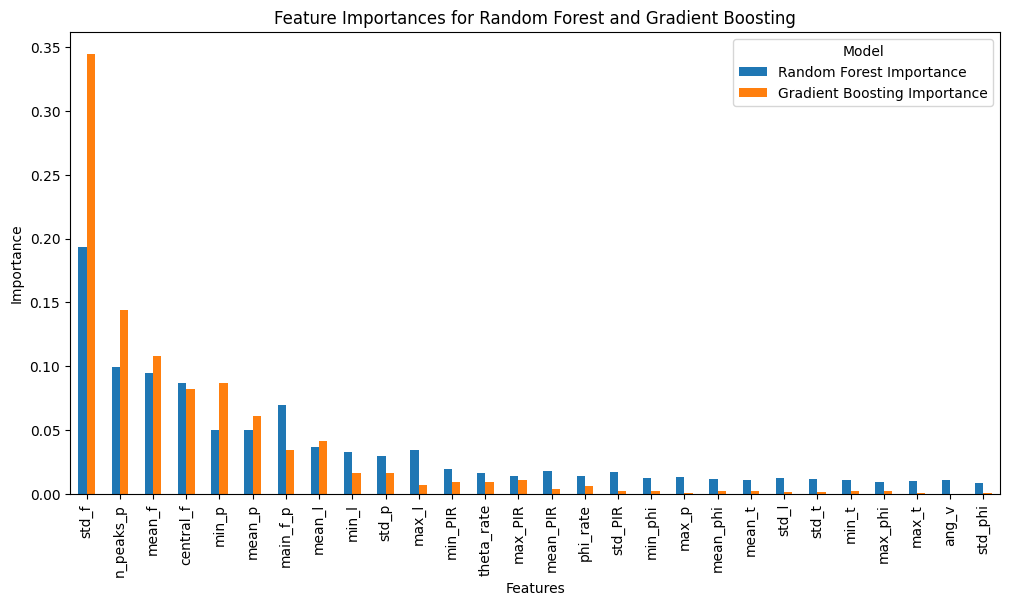

In [86]:
# Graphique des importances des features
importances_df.plot(x='Feature', y=['Random Forest Importance', 'Gradient Boosting Importance'], kind='bar', figsize=(12, 6))
plt.title("Feature Importances for Random Forest and Gradient Boosting")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.legend(title="Model")
plt.show()


On conclut que les variables les plus utiles pour la classification sont l'écart-type de la fréquence et le nombre de pics de la puissance. L'écart-type permettait déjà de discriminer les signaux pour l'algorithme naïf, et le *feature engineering* nous a permis de créer la nouvelle variable `n_peaks`, qui a significativement amélioré notre score.

Pour aller plus loin, on pourrait effectuer des analyses en PCA et t-SNE afin de concentrer l'information, ce qui pourrait améliorer encore l'efficacité de la classification. On pourrait également procéder à une recherche des meilleurs hyperparamètres pour optimiser nos classifieurs.

**Merci d'avoir lu notre TP.**

**Blandine Gorce et Thomas Gravier**